### import

In [1]:
import pandas as pd

### 데이터 가져오기


In [2]:
# 코랩 mount
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/기계학습이해/"

# root_path = "C:/Users/user/Desktop/기계학습이해/"

# 데이터 읽어오기
df1 = pd.read_csv(root_path+"Dataset/(자동차보험) 고객별 사고 발생률 예측 모델링_1.csv", encoding = "cp949", engine='python')
df2 = pd.read_csv(root_path+"Dataset/(자동차보험) 고객별 사고 발생률 예측 모델링_2.csv", encoding = "cp949", engine='python')
df3 = pd.read_csv(root_path+"Dataset/(자동차보험) 고객별 사고 발생률 예측 모델링_3.csv", encoding = "cp949", engine='python')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# 데이터 이상 없는 df의 column 확인
col = df2.columns

# 오류로 생성된 column 삭제
df1 = df1[col]


#df1의 파일상 null 행 삭제
null_idx = df1[df1["차종"].isnull()].index.tolist()
df1 = df1.drop(index = null_idx)


# 데이터 프레임 합치기
df = pd.concat([df1, df2, df3], ignore_index = True)
df

In [ ]:
# 수치형인데 object인 column 형변환
df['YUHO'] = df['YUHO'].str.replace(',', '').astype(int)
df['SAGO'] = df['SAGO'].apply(lambda x: int(float(str(x).replace(',', '').split('.')[0])))
df['SAGO'] = df['SAGO'].replace(',', '').astype(int)

# column명 한글로 변환
df = df.rename(columns = {"ZINSRDAVL": "연령대", "ZIOSEXCD": "성별",
                        "ZDPRODSCD": "국산차량여부", "NCR": "직전3년간사고건수",
                        "ZCARPSGVL": "차량경과년수", "ZDRVLISCD___T": "운전자한정특별약관",
                        "ZENTCARCD": "가입경력코드", "ZCARISDAM": "차량가입금액",
                        "ZIMAGERVL": "영상기록장치특약가입", "YUHO": "유효대수",
                        "SAGO" : "사고건수"})

# 사용하지 않는 column drop
df = df.drop(columns = ['ZCPRLCLCD', 'ZDRVLISCD'])



df

In [ ]:
# 사고율 / 사고유무 df 생성
df['사고유무'] = df.apply(lambda row: 0 if row['사고건수'] == 0 else 1, axis = 1)
df_yn = df.drop(columns = ['사고건수'])

In [ ]:
# x, y 분리
yn_X = df_yn.drop(columns = ["사고유무"])
yn_y = df_yn["사고유무"]

In [ ]:
yn_X

In [ ]:

# 결측치 제거
df_yn.isnull().sum()

In [ ]:

df_yn = df_yn.dropna()
df_yn.isnull().sum()

In [ ]:

# 데이터 type 변환

df_yn["연령대"] = df_yn["연령대"].astype(int)
df_yn["성별"] = df_yn["성별"].astype(int)
df_yn["국산차량여부"] = df_yn["국산차량여부"].astype(int)
df_yn["가입경력코드"] = df_yn["가입경력코드"].astype(int)


In [ ]:

# 모델에 넣기 위해 categorical 변수 Label Encoding

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

category = (df_yn.dtypes == object)
categorical_col = df_yn.columns[category].tolist()

for col_name in categorical_col:
    le = LabelEncoder()
    le = le.fit(df_yn[col_name])
    df_yn[col_name] = le.transform(df_yn[col_name])

### 모델


In [ ]:

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, mean_squared_error, precision_score, recall_score
from sklearn.model_selection import KFold
import math


In [ ]:
# 로지스틱 회귀 함수
def SVC_classifier(X, y):

    # LogisticRegression 초기화
    model = SVC()

    # 오차를 저장할 DataFrame 생성
    accuracy = []
    err = []
    precision = []
    recall = []
    auc = []

    # 학습 100번 실행
    for i in range(100):

        # train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, stratify = y)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1].reshape(-1,1)

        # 평가지표 저장
        accuracy.append(accuracy_score(y_test, y_pred))
        err.append((1 - accuracy_score(y_test, y_pred)))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_proba))

        # print
        print(f"{i+1}번째 완료")

    result = pd.DataFrame(zip(accuracy, err, auc, precision, recall))
    result.columns = ['accuracy', 'error rate', 'AUC', 'precision', 'recall']

    return result


In [ ]:

from sklearn.model_selection import GridSearchCV, KFold
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from itertools import product
from tqdm import tqdm




In [ ]:
accuracy_list =[]

best_params_list = []


for _ in tqdm(range(100)):
    model = xgb.XGBClassifier()


    # x, y 분리
    yn_X = df_yn.drop(columns = ["사고유무"])
    yn_y = df_yn["사고유무"]


    # train, test 분리
    X_train, X_test, y_train, y_test = train_test_split(yn_X, yn_y ,test_size = 0.2)


    # 인덱스를 재설정하여 0부터 시작하는 연속적인 정수 인덱스를 부여합니다.
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # train set에서 1000개의 데이터를 랜덤으로 추출합니다.
    random_indices = np.random.choice(len(X_train), size=1000, replace=False)
    X_train_subset = X_train.loc[random_indices]
    y_train_subset = y_train.loc[random_indices]


    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200, 500]
    }


    # 이거는 하나씩 파라미터 조합 만드는 방법
    # for params_values in product(*parameters.values()):
    #   now_param = dict(zip(parameters.keys(), params_values))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)

    grid_search.fit(X_train_subset, y_train_subset)
    best_params_list.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)  # 테스트 데이터에 대한 예측 수행
    accuracy_list.append(accuracy_score(y_test, y_pred))

100%|██████████| 100/100 [20:36<00:00, 12.36s/it]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

accuracy_list_gradient = []
best_params_list_gradient = []

for _ in tqdm(range(100)):
    model = GradientBoostingClassifier()

    # x, y 분리
    yn_X = df_yn.drop(columns=["사고유무"])
    yn_y = df_yn["사고유무"]

    # train, test 분리
    X_train, X_test, y_train, y_test = train_test_split(yn_X, yn_y, test_size=0.2)

    # 인덱스를 재설정하여 0부터 시작하는 연속적인 정수 인덱스를 부여합니다.
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # train set에서 1000개의 데이터를 랜덤으로 추출합니다.
    random_indices = np.random.choice(len(X_train), size=1000, replace=False)
    X_train_subset = X_train.loc[random_indices]
    y_train_subset = y_train.loc[random_indices]

    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200, 500]
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)

    grid_search.fit(X_train_subset, y_train_subset)
    best_params_list_gradient.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)  # 테스트 데이터에 대한 예측 수행
    accuracy_list_gradient.append(accuracy_score(y_test, y_pred))


100%|██████████| 100/100 [1:12:38<00:00, 43.58s/it]


In [ ]:
from sklearn.svm import SVC

accuracy_list_svm = []
best_params_list_svm = []

for _ in tqdm(range(100)):
    model = SVC()

    # x, y 분리
    yn_X = df_yn.drop(columns=["사고유무"])
    yn_y = df_yn["사고유무"]

    # train, test 분리
    X_train, X_test, y_train, y_test = train_test_split(yn_X, yn_y, test_size=0.2)

    # 인덱스를 재설정하여 0부터 시작하는 연속적인 정수 인덱스를 부여합니다.
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # train set에서 1000개의 데이터를 랜덤으로 추출합니다.
    random_indices = np.random.choice(len(X_train), size=1000, replace=False)
    X_train_subset = X_train.loc[random_indices]
    y_train_subset = y_train.loc[random_indices]

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kf)

    grid_search.fit(X_train_subset, y_train_subset)
    best_params_list_svm.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)  # 테스트 데이터에 대한 예측 수행
    accuracy_list_svm.append(accuracy_score(y_test, y_pred))


100%|██████████| 100/100 [17:14<00:00, 10.34s/it]


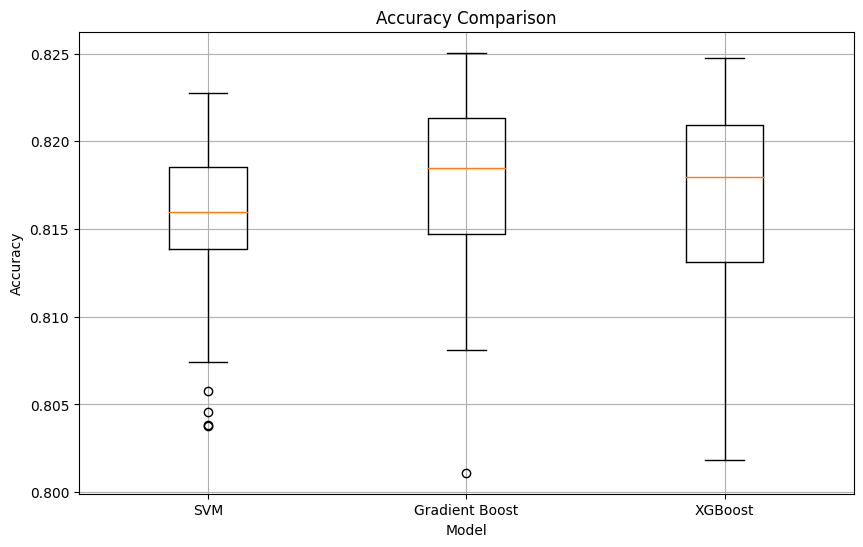

In [ ]:
import matplotlib.pyplot as plt

# 모델의 정확도 리스트들을 하나의 리스트에 모아줍니다.
accuracy_lists = [accuracy_list_svm, accuracy_list_gradient, accuracy_list]
labels = ['SVM', 'Gradient Boost', 'XGBoost']

# Boxplot을 그립니다.
plt.figure(figsize=(10, 6))
plt.boxplot(accuracy_lists, labels=labels)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
# 0. 모델 선정
# 1. test 100번 (외부 반복문)
# 2. train test 나누기 (8:2)
# 3. train data 중에 1000개 추출
# 4. 파라미터 별로 반복 (그리디 서치)
# 5. cross validation (5회 반복) (평균 추출?)
# 6. best parameter 뽑아 test set 추론 후 값 저장
# 7. test 100번 완료 후 boxplot 그리기.





